<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/main/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binôme T: De Carvalho Mickael et Laisney Clément

algorithme qui prédit le style de l'oeuvre d'art (impressionnisme, pop art, cubisme etc...) et peut être je dit bien PEUT ETRE 
arriver à un algorithme qui créer une oeuvre en fonction du style demandé.

jeu de données:
https://www.kaggle.com/ikarus777/best-artworks-of-all-time

points de départ: 

- réseau de convolution
- réduction de dimension pour classer 

retrouvez notre travail sur https://github.com/sirius59/ART_AI

### Import libraries

In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import to_categorical

### Download the dataset from internet and extract it on the system

**We resized all images to 500x500 with a preview script available in the github page:** https://github.com/sirius59/ART_AI/blob/main/traitement%20des%20images.py

NB1: the csv file is a bit modified. replace space by underscore in artists names, set one genre per artists.

NB2: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [3]:
zipurl = 'https://download857.mediafire.com/fy4nqnkol7kg/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Core of the script

We first want to make a binary classification between 2 genre well represented in the dataset. We choose Impressionism and Baroque.

## Extracting metadata from artist.csv and labelize genres

In [4]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
name=artists.name

##genre of artists
genre=artists.genre

##number of paintings by artists
nb_paints=artists.paintings

Labelize a genre with a number

In [5]:
genre_label={'Impressionism':0,'Baroque':1}

In [6]:
nb_classes=len(genre_label)

Function to find the key associated with the label

In [7]:
def find_key(v): 
    for k, val in genre_label.items(): 
        if v == val: 
            return k 
    return "Key does not exist"

## Append artworks of 2 differents styles in a list
We choose 2 differents styles well represented in the dataset en choose 4 artists of each genre in order to have about 50/50 in term of artworks

In [8]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape#shape of images
artworks=[]
artworks_genre=[]
genre1=(3,14,15,20,25,27,31) #selected artists in order to have ~50/50 impressionism/Baroque

for i in genre1:
  for j in range(nb_paints[i]):
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))
    artworks_genre.append(genre[i])

artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

We choose to represent 2 differents artworks of each genre in order to visualize datas

Text(0.5, 1.0, 'Baroque')

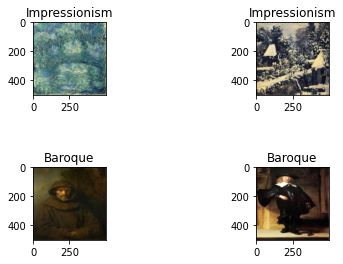

In [9]:
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[0])
plt.title(f'{artworks_genre[0]}')
plt.subplot(222)
plt.imshow(artworks[300])
plt.title(f'{artworks_genre[300]}')
plt.subplot(223)
plt.imshow(artworks[-1])
plt.title(f'{artworks_genre[-1]}')
plt.subplot(224)
plt.imshow(artworks[-200])
plt.title(f'{artworks_genre[-200]}')

## Shuffle and split of the dataset

In [10]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes) #convert label into a matrix eg: label 0 --> [1,0]; label 1 --> [0,1]

In [11]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)
#split and shuffle the dataset into train and test datasets

## CNN

This is the Convolutional Network

In [12]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))

model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 496, 496, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 248, 248, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 245, 245, 128)     131200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 243, 243, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 121, 121, 128)     0         
_________________________________________________________________
flatten (Flatten)            (None, 1874048)           0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [15]:
history=model.fit(x_train,y_train, batch_size=64, epochs=10, validation_split=0.33)

Epoch 1/10


ResourceExhaustedError: ignored

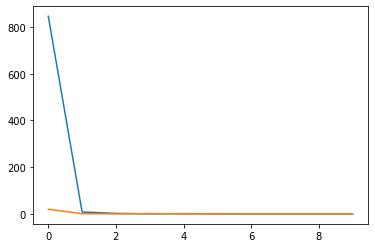

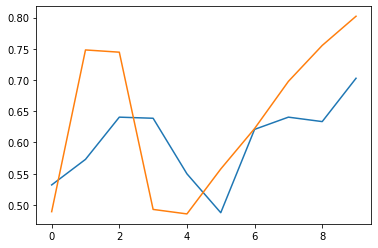

In [ ]:
plt.figure()
plt.plot(history.history['loss'][1:])#first value is often bigger than the rest
plt.plot(history.history['val_loss'][1:])

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
predict=model.predict(x_test)

In [ ]:
label_prediction=np.argmax(predict, axis=1)
#select the label with the highest probability eg: [0.2,0.8] --> label_prediction=1, [0.7,0.3] --> label_prediction=0
label_solution=np.argmax(y_test, axis=1)#select the label of the solution eg: [0,1] --> label_prediction=1, [1,0] --> label_prediction=0

visualisation of random predictions with solutions

Text(0.5, 1.0, 'prediction:Impressionism\n solution:Impressionism')

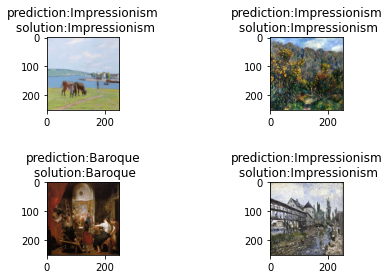

In [ ]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [ ]:
correct=len(np.where(label_prediction==label_solution)[0]) #count the number of correct prediction
bad=len(np.where(label_prediction!=label_solution)[0]) #count the number of incorrect prediction

In [ ]:
efficacity=correct/(correct+bad)
print(efficacity)

4.3076923076923075
